# 2017年度リーディングDAT L-B2 課題

##### 2018/03/11 鈴木 毅洋

* 課題設定： 映画のレコメンデーション
* 使用したデータ: 映画推薦システム用データセット Movie Lens  
下記URLから取得した。  
https://github.com/oreilly-japan/ml-at-work  
[概要](http://yag.xyz/blog/2015/10/03/movielens-datasets/)：
>推薦システムの開発やベンチマークのために作られた，映画のレビューためのウェブサイトおよびデータセット．ミネソタ大学のGroupLens Researchプロジェクトの一つで，研究目的・非商用でウェブサイトが運用されており，ユーザが好きに映画の情報を眺めたり評価することができる．

* 用いた手法： Factorization Machines  
協調フィルタリングやNMFに並び、モデルベースのレコメンデーションとして知られるアルゴリズムである。

> FMはSVDやMFとはRatingの持ち方が異なっています。
SVDやMFは1行に1ユーザの評価データを複数格納しており、これをユーザとアイテムの特徴ベクトルをそれぞれ取り出しています。
これに対して、FMは1評価を1行で表し、取り出すのはユーザとアイテムの交互作用(pair-wise)の特徴ベクトルで、SVDやMFとは注目している対象が異なります。
![手法の違い](https://camo.qiitausercontent.com/9a1dcc3a15f83b1bc1da098c6d80f743c145735c/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f31323136352f62343537656133662d346232302d323135612d366637642d3162376435363433383564382e706e67)

なお数式モデルは以下式で与えられる。  

$ŷ (x⃗ )=w_0+∑_{i=1}^{n}w_ix_i+∑_{i=1}^{n}∑_{j=i+1}^n(v⃗ _i⋅v⃗ _j)x_i$  
ここで$w_0,w_i∈ℝ, v⃗ _i∈ℝ$で、次元rがハイパーパラメータとなる。  

上記のように、１行１評価の形でデータを持つことで、User・Item以外の要素(コンテキスト)を加えることが可能であり、  
より柔軟なモデリングが可能である。

論文:  
https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf  
参考ページ:  
https://qiita.com/wwacky/items/b402a1f3770bee2dd13c  
http://tech-blog.fancs.com/entry/factorization-machines  
参考書籍：  
[仕事ではじめる機械学習 オライリー・ジャパン](https://www.oreilly.co.jp/books/9784873118215/)



## EDA (Exploratory Data Analysis)

様々な切り口でデータを眺め、概要を把握する。

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fastFM

plt.style.use("ggplot")

### データの読み込み

In [3]:
# ユーザー情報
u_cols = ["user_id","age","sex","occupation","zip-code"]
users = pd.read_csv("../data/ml-100k/u.user",sep="|",names=u_cols)

# 評価値情報
r_cols = ["user_id","movie_id","rating","unix_timestamp"]
ratings = pd.read_csv("../data/ml-100k/u.data",sep="\t",names=r_cols)
ratings["date"] = pd.to_datetime(ratings.unix_timestamp,unit="s")

# 映画情報
m_cols = ["movie_id","title","release_date","video_release_date","imdb_url"]
movies = pd.read_csv("../data/ml-100k/u.item",sep="|",names=m_cols,usecols=range(5),encoding="latin1")

# 全てのデータをマージ
movie_rating = pd.merge(movies,ratings)
lens = pd.merge(movie_rating,users)

In [7]:
lens.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,date,age,sex,occupation,zip-code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,1998-02-17 17:51:30,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,1998-02-17 18:20:08,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,1998-02-17 18:07:27,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,1998-02-17 17:31:36,60,M,retired,95076


### Summary

In [8]:
# 最も評価された回数の多い25作品のタイトル
lens.title.value_counts().head(25)

Star Wars (1977)                             583
Contact (1997)                               509
Fargo (1996)                                 508
Return of the Jedi (1983)                    507
Liar Liar (1997)                             485
English Patient, The (1996)                  481
Scream (1996)                                478
Toy Story (1995)                             452
Air Force One (1997)                         431
Independence Day (ID4) (1996)                429
Raiders of the Lost Ark (1981)               420
Godfather, The (1972)                        413
Pulp Fiction (1994)                          394
Twelve Monkeys (1995)                        392
Silence of the Lambs, The (1991)             390
Jerry Maguire (1996)                         384
Chasing Amy (1997)                           379
Rock, The (1996)                             378
Empire Strikes Back, The (1980)              367
Star Trek: First Contact (1996)              365
Back to the Future (

* 2000年以前の映画が多い。古い映画の方が評価人数が多いため？  
→映画ごとに評価の数と平均を集計し、平均値の高い順に並べてみる

In [9]:
# 100件以上評価されているタイトルのみを対象
atleast_100 = movie_stats["rating"]["size"] >= 100
movie_stats[atleast_100].sort_values(by=[("rating","mean")],ascending=False).head(15)

rating          
                                         size      mean
title                                                  
Close Shave, A (1995)                     112  4.491071
Schindler's List (1993)                   298  4.466443
Wrong Trousers, The (1993)                118  4.466102
Casablanca (1942)                         243  4.456790
Shawshank Redemption, The (1994)          283  4.445230
Rear Window (1954)                        209  4.387560
Usual Suspects, The (1995)                267  4.385768
Star Wars (1977)                          583  4.358491
12 Angry Men (1957)                       125  4.344000
Citizen Kane (1941)                       198  4.292929
To Kill a Mockingbird (1962)              219  4.292237
One Flew Over the Cuckoo's Nest (1975)    264  4.291667
Silence of the Lambs, The (1991)          390  4.289744
North by Northwest (1959)                 179  4.284916
Godfather, The (1972)                     413  4.283293

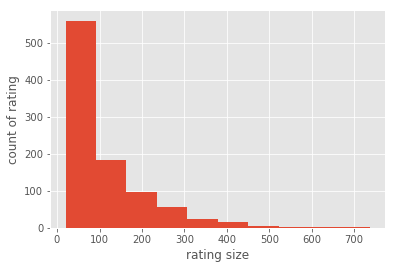

In [10]:
# 評価回数の分布
lens.groupby("user_id").size().sort_values(ascending=False).hist()
plt.xlabel("rating size")
plt.ylabel("count of rating")

* 沢山のタイトルを評価しているユーザーは少なく、逆も然りである。  
典型的なロングテールの分布であることがわかる

In [12]:
# ユーザーごとの評価数と評価値の平均
user_stats = lens.groupby("user_id").agg(dict(rating=[np.size,np.mean]))
user_stats.rating.describe()

,size,mean
count,943.000000,943.000000
mean,106.044539,3.588191
std,100.931743,0.445233
min,20.000000,1.491954
25%,33.000000,3.323054
50%,65.000000,3.620690
75%,148.000000,3.869565
max,737.000000,4.869565


* 評価値の平均が1.49と辛口のユーザーもいれば、4.87と甘口のユーザーも居る

## Factorization Machinsによるレコメンデーション

* 提案者の実装した[libFMというライブラリ](http://www.libfm.org/)を使用  
(実際にはPythonでラップしたfastFMを使用)
* ALS, SGD, MCMCの３種の実装が存在し、場合に応じて使い分けることが可能

In [17]:
from fastFM import mcmc
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [14]:
# 前処理
lens["user_id"] = lens["user_id"].astype(str)
lens["movie_id"] = lens["movie_id"].astype(str)
lens["year"] = lens["date"].apply(str).str.split("-").str.get(0)
lens["release_year"] = lens["release_date"].apply(str).str.split("-").str.get(2)
lens["year"] = lens["date"].apply(str).str.split("-").str.get(0)
lens["release_year"] = lens["release_date"].apply(str).str.split("-").str.get(2)

* 下記の複数の特徴量の組み合わせの中から、最も良いものを選択する

In [15]:
# 特徴量の組み合わせ候補
candidate_columns = [
    ["user_id","movie_id","release_year","age","sex","year","rating"],  #A
    ["user_id","movie_id","age","sex","year","rating"],  #B
    ["user_id","movie_id","sex","year","rating"],  #C
    ["user_id","movie_id","age","sex","rating"],   #D
    ["user_id","movie_id","rating"],  #E
]

In [19]:
rmse_test = []

for column in candidate_columns:
    # 欠損値削除
    filtered_lens = lens[column].dropna()
    # 入力データをダミー変数に変換
    v = DictVectorizer()
    X_more_feature = v.fit_transform(
        list(filtered_lens.drop("rating",axis=1).T.to_dict().values()))
    y_more_feature = filtered_lens["rating"].tolist()
    
    # 教師データの学習用と評価用の分割
    X_mf_train,X_mf_test,y_mf_train,y_mf_test = train_test_split(
        X_more_feature,y_more_feature,test_size=.1,random_state=42)
    
    # ratingの正規化
    scaler = StandardScaler()
    y_mf_train_norm = scaler.fit_transform(np.array(y_mf_train).reshape(-1, 1)).ravel()
    
    # MCMCを使ったモデルの学習
    fm = mcmc.FMRegression(n_iter=500,rank=8,random_state=123)
    fm.fit_predict(X_mf_train,y_mf_train_norm,X_mf_test)
    
    # テストデータでの予測結果のRMSE取得
    y_pred = fm.fit_predict(X_mf_train,y_mf_train_norm,X_mf_test)
    rmse = np.sqrt(
        mean_squared_error(scaler.inverse_transform(y_pred.reshape(-1, 1)),y_mf_test))
    rmse_test.append(rmse)

/Users/apple/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


(0.88, 0.9)

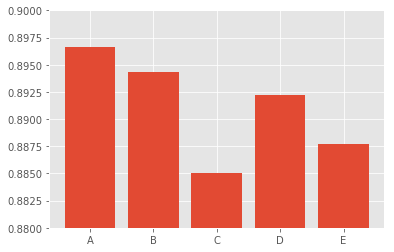

In [21]:
# RMSEのプロット
ind = np.arange(len(rmse_test))
bar = plt.bar(ind,height=rmse_test)
plt.xticks(ind,["A","B","C","D","E"])
plt.ylim((0.88,0.90))

* 上記結果より、(ユーザーID・映画ID・性別・評価年)の組み合わせが良いことがわかる
* 次に、上記組み合わせの中で、適当なrankの値を選択する

In [23]:
#　最も良い特徴量の組み合わせ
best_column = ["user_id","movie_id","sex","year","rating"]
# rankの候補
ranks = [4,8,16,32,64]

In [24]:
rmse_test = []
for rank in ranks:
    # 欠損値削除
    filtered_lens = lens[best_column].dropna()
    # 入力データをダミー変数に変換
    v = DictVectorizer()
    X_more_feature = v.fit_transform(
        list(filtered_lens.drop("rating",axis=1).T.to_dict().values()))
    y_more_feature = filtered_lens["rating"].tolist()
    
    # 教師データの学習用と評価用の分割
    X_mf_train,X_mf_test,y_mf_train,y_mf_test = train_test_split(
        X_more_feature,y_more_feature,test_size=.1,random_state=42)
    
    # ratingの正規化
    scaler = StandardScaler()
    y_mf_train_norm = scaler.fit_transform(np.array(y_mf_train).reshape(-1, 1)).ravel()
    
    # MCMCを使ったモデルの学習
    fm = mcmc.FMRegression(n_iter=500,rank=rank,random_state=123)
    fm.fit_predict(X_mf_train,y_mf_train_norm,X_mf_test)
    
    # テストデータでの予測結果のRMSE取得
    y_pred = fm.fit_predict(X_mf_train,y_mf_train_norm,X_mf_test)
    rmse = np.sqrt(
        mean_squared_error(scaler.inverse_transform(y_pred.reshape(-1, 1)),y_mf_test))
    rmse_test.append(rmse)
    print("rank:{}\trmse:{:.3f}".format(rank,rmse))

/Users/apple/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


rank:4	rmse:0.889
rank:8	rmse:0.885
rank:16	rmse:0.885
rank:32	rmse:0.886
rank:64	rmse:0.887


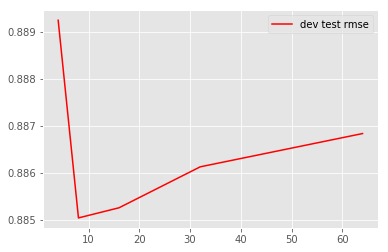

In [25]:
# 結果のプロット
plt.plot(ranks,rmse_test,label="dev test rmse",color="r")
plt.legend()

* 僅差ではあるが、rank=8の時に最もRMSEが小さい

In [27]:
# 検証データの標準偏差（＝常に平均値を出力するモデルのRMSE。モデルの良さのベンチマーク）
np.std(y_more_feature)

1.1256679707622492

* Factorization MachinesのRMSEはテストデータの標準偏差1.13を下回っている。  
つまり、常に平均値を出力する予測モデルより良いモデルが作成できたといえる

## 備考